In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [39]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# neural network
class ShallowNet(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, 10)
        # He initialization
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [41]:
# Minist dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# get 1000 samples per label
class_counts = [1000] * 10
indices = torch.cat([torch.where(mnist_train.targets == i)[0][:n] for i, n in enumerate(class_counts)])
balanced_train_dataset = Subset(mnist_train, indices)

train_dataset = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
test_dataset = DataLoader(mnist_test, batch_size=1000, shuffle=False)

In [42]:
width_grid = [1, 5, 10, 20, 40]
dropout_grid = [0.1, 0.5, 1.0]
epochs = 80

In [46]:
def train_and_evaluate_model(hidden_units, dropout_rate, index1):
    model = ShallowNet(28*28, hidden_units, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    performance_recoed = {'train_acc': [], 'test_acc': [], 'loss': []}

    index1 = index1
    id = 0

    for epoch in range(epochs):
        # Training
        model.train()
        correct_train = 0
        total_train = 0
        total_loss = 0

        for batch_idx, (data, target) in enumerate(train_dataset):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()


        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_dataset:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        loss = total_loss/len(train_dataset)

        train_acc = correct_train / total_train
        test_acc = correct_test / total_test
        train_record[index1][id] = train_acc
        test_record[index1][id] = test_acc
        loss_record[index1][id] = loss

        performance_record['train_acc'].append(train_acc)
        performance_record['test_acc'].append(test_acc)
        performance_record['loss'].append(loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        id += 1

    return performance_record

In [48]:
# setup for varying choices of k and p automatically
results = {}
train_record = [[0 for i in range(80)] for j in range(15)]
test_record = [[0 for i in range(80)] for j in range(15)]
loss_record = [[0 for i in range(80)] for j in range(15)]
index1 = 0
for hidden_units in width_grid:
    for dropout_rate in dropout_grid:
        print(f"\nTraining model with {hidden_units} hidden units and dropout rate of {dropout_rate}")
        history = train_and_evaluate_model(hidden_units, dropout_rate, index1)
        results[(hidden_units, dropout_rate)] = history
        index1 += 1
        print(train_record)
        print(test_record)
        print(loss_record)

print("\nTraining and evaluation complete.")


Training model with 1 hidden units and dropout rate of 0.1
1
0.1
Epoch 1/80, Loss: 2.3017, Train Acc: 0.0963, Test Acc: 0.1448
Epoch 2/80, Loss: 2.1946, Train Acc: 0.1551, Test Acc: 0.1895
Epoch 3/80, Loss: 2.1067, Train Acc: 0.1809, Test Acc: 0.1852
Epoch 4/80, Loss: 2.0627, Train Acc: 0.1814, Test Acc: 0.1848
Epoch 5/80, Loss: 2.0388, Train Acc: 0.1825, Test Acc: 0.1973
Epoch 6/80, Loss: 2.0241, Train Acc: 0.1954, Test Acc: 0.2026
Epoch 7/80, Loss: 2.0073, Train Acc: 0.1962, Test Acc: 0.2040
Epoch 8/80, Loss: 1.9931, Train Acc: 0.2043, Test Acc: 0.2087
Epoch 9/80, Loss: 1.9776, Train Acc: 0.2041, Test Acc: 0.2102
Epoch 10/80, Loss: 1.9727, Train Acc: 0.2026, Test Acc: 0.2128
Epoch 11/80, Loss: 1.9713, Train Acc: 0.2030, Test Acc: 0.2079
Epoch 12/80, Loss: 1.9614, Train Acc: 0.2098, Test Acc: 0.2107
Epoch 13/80, Loss: 1.9531, Train Acc: 0.2073, Test Acc: 0.2107
Epoch 14/80, Loss: 1.9520, Train Acc: 0.2134, Test Acc: 0.2149
Epoch 15/80, Loss: 1.9539, Train Acc: 0.2111, Test Acc: 0.216

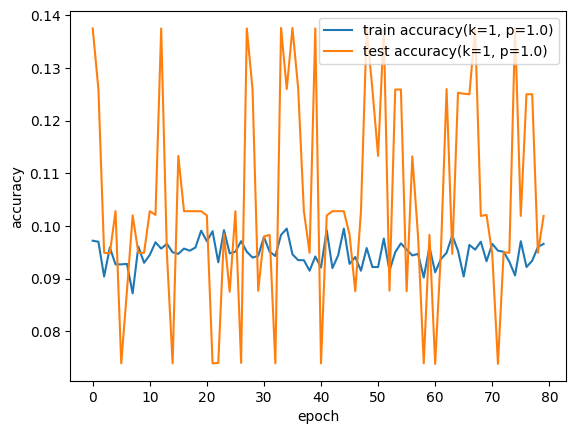

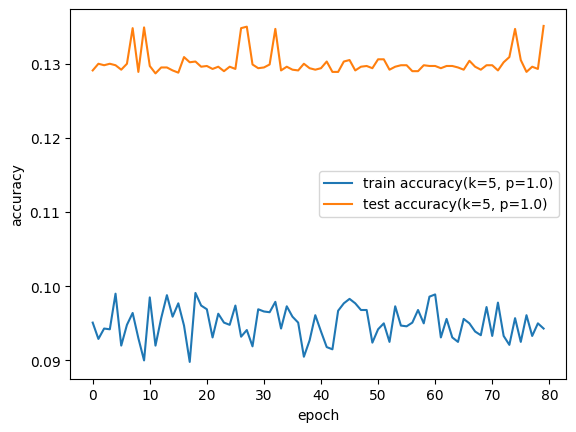

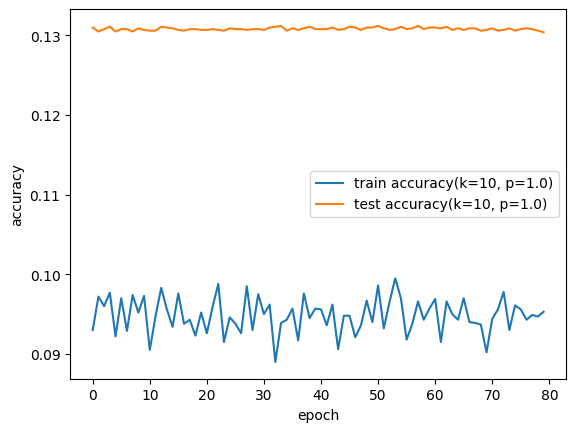

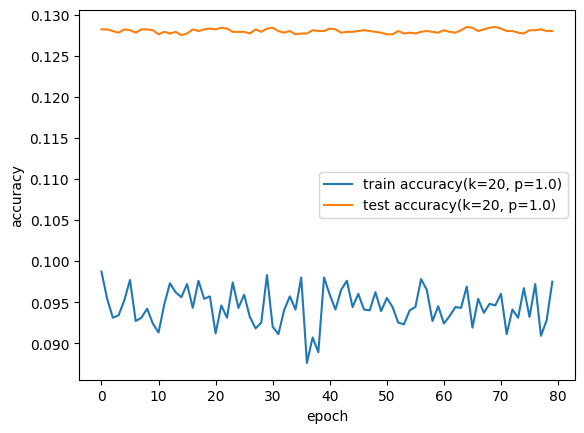

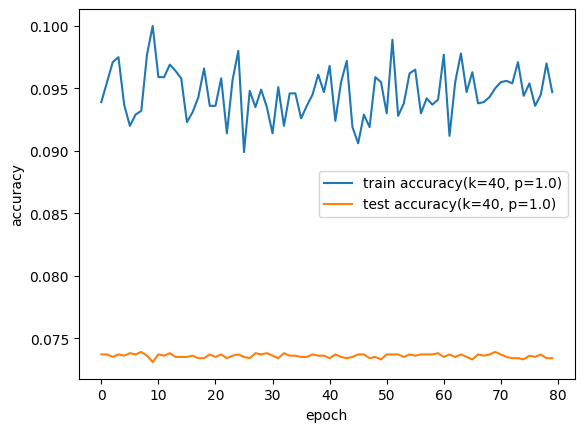

In [49]:
# fix p = 1.0
import matplotlib.pyplot as plt

temp = [i for i in range(80)]
num = 2

for i in width_grid:
  plt.plot(temp, train_record[num], label=f'train accuracy(k={i}, p=1.0)')
  plt.plot(temp, test_record[num], label=f'test accuracy(k={i}, p=1.0)')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()
  num += 3

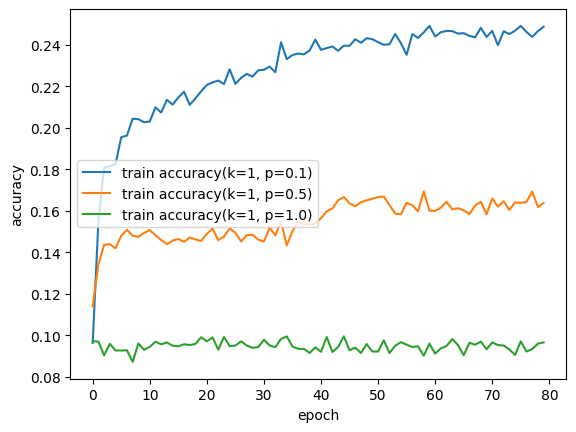

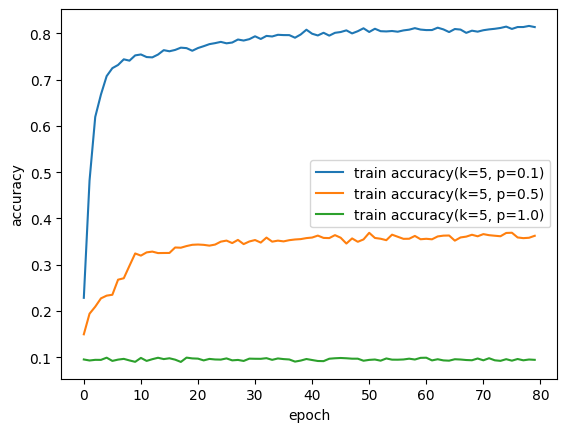

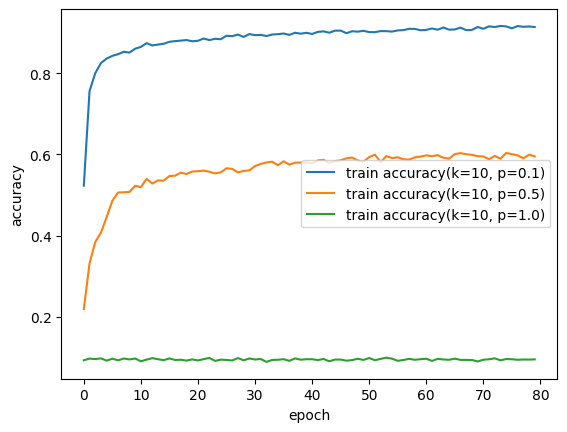

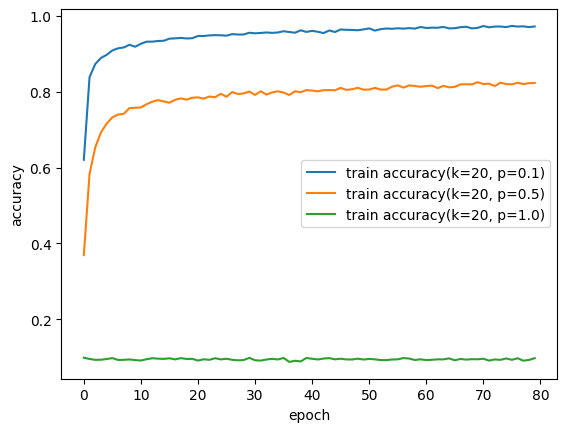

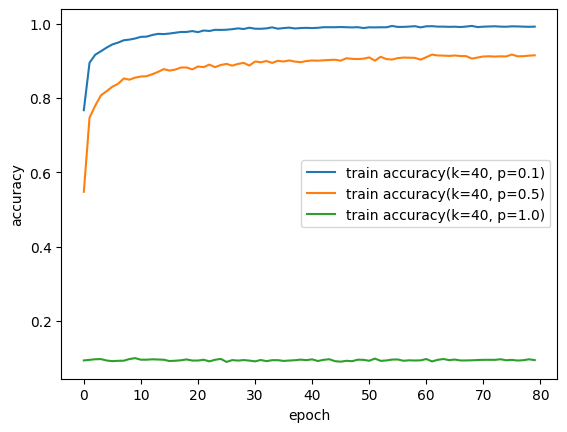

In [50]:
# training accuracy for k with dofferent p
import matplotlib.pyplot as plt

temp = [i for i in range(80)]
num = 0

for i in width_grid:
  plt.plot(temp, train_record[num], label=f'train accuracy(k={i}, p=0.1)')
  plt.plot(temp, train_record[num+1], label=f'train accuracy(k={i}, p=0.5)')
  plt.plot(temp, train_record[num+2], label=f'train accuracy(k={i}, p=1.0)')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()
  num += 3

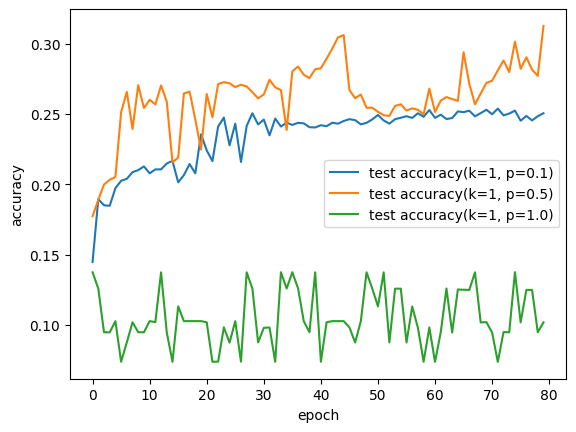

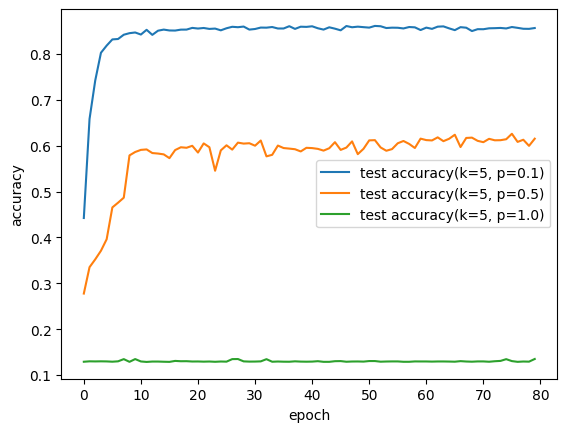

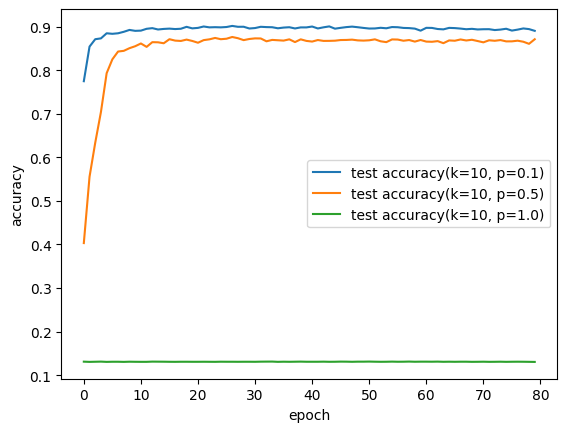

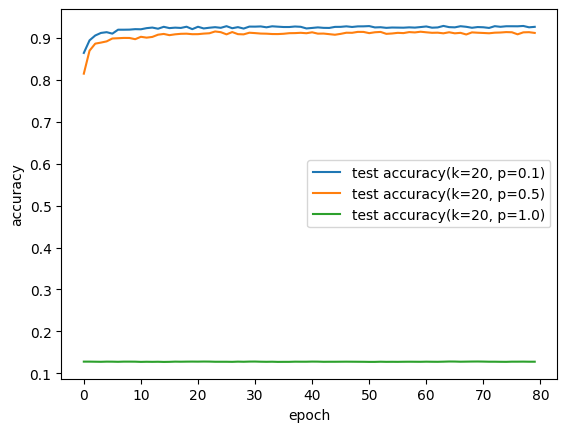

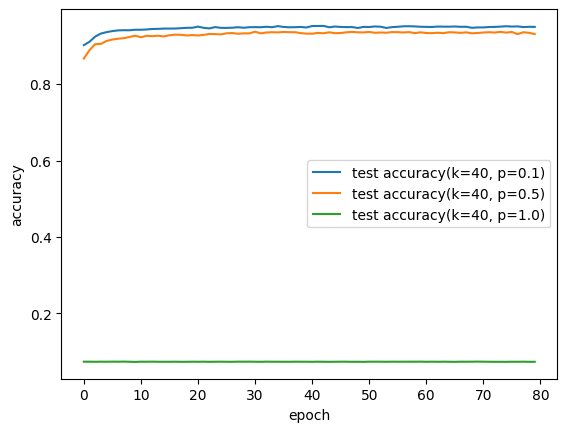

In [51]:
# test accuracy for k with dofferent p
import matplotlib.pyplot as plt

temp = [i for i in range(80)]
num = 0

for i in width_grid:
  plt.plot(temp, test_record[num], label=f'test accuracy(k={i}, p=0.1)')
  plt.plot(temp, test_record[num+1], label=f'test accuracy(k={i}, p=0.5)')
  plt.plot(temp, test_record[num+2], label=f'test accuracy(k={i}, p=1.0)')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()
  num += 3